In [83]:
import keras as keras
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization
from keras.initializers import glorot_uniform
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Resizing, RandomCrop, RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [84]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import math
from IPython.display import Image
import math 

# ResNet
> 잔차 네트워크(residual network)를 사용한 구조 <br>
Kaiming He 등이 ILSVRC 2015 대회에서 승리 (3.6% 에러) <br>
152개 층 (34, 50, 101개 변종도 있다.) <br>
Skip connection (shortcut connection), identity function


### Load data

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ti = x_train[0]
print(ti.shape)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

def augmentattion(x_train, y_train, resizing) :
    
    model = Sequential([Rescaling(1/255.),
                        resizing,
                       RandomCrop(32,32), # 32 X 32로 조정되어 중심축이 변경되며 일부가 잘려진다.
                       RandomFlip('horizontal'),
                       RandomRotation(np.random.randint(0,360))])

    Model.build(model, (1, ti.shape[0], ti.shape[1], 3)) # 3차원
    
    globals()[f"x_train_2"] = model(x_train)
                
    # 데이터 결합
    globals()[f"x_train_all"] = np.concatenate((x_train, x_train_2), axis=0) 
    globals()[f"y_train_all"] = np.concatenate((y_train, y_train), axis=0)
    
    
    
resizing = Resizing(int(ti.shape[0]*1.1), int(ti.shape[1]*1.1)) 
augmentattion(x_train, y_train, resizing)

(32, 32, 3)
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


2022-12-07 11:03:42.075915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-12-07 11:03:47.396598: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9


### model 설계

In [8]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [76]:
def deepConv2D(x, fts, kns, std, name, num) :
#     st = 1
#     if std == 2 : st == 2
#     else : st == 1
        
    y = Conv2D(filters=fts, kernel_size=kns, strides=std, padding='same', activation='relu', 
              kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    y = BatchNormalization()(y)
    
    for i in range(num-1) :
        y = Conv2D(filters=fts, kernel_size=kns, strides=1, padding='same', activation='relu', 
                  kernel_initializer=kernel_init, bias_initializer=bias_init)(y)
        y = BatchNormalization()(y)
    
    if std == 2 :
        x = Conv2D(filters=fts, kernel_size=1, strides=2, padding='same', activation='relu', 
                  kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
        x = BatchNormalization()(x)

      
    output = x + y
    return output    

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


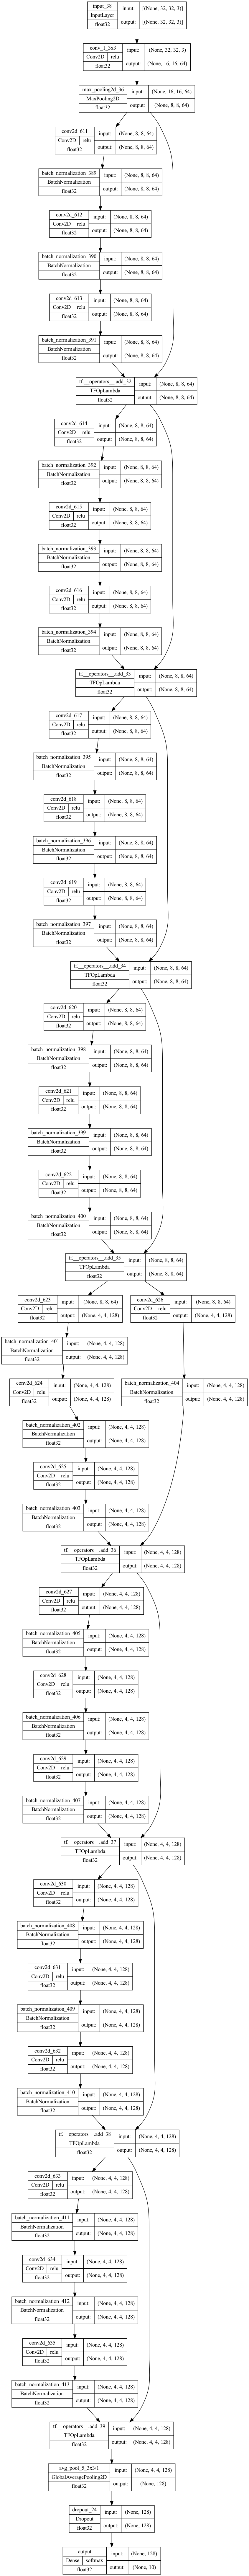

In [170]:
input_layer = Input(x_train_all.shape[1:])

x = Conv2D(64, (3, 3), strides=(2,2), padding='same', activation='relu', name='conv_1_3x3', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2))(x)
x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/1", 3)
x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/2", 3)
x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/3", 3)
x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/4", 3)

x = deepConv2D(x, 128, (3,3), 2, "Conv2D/128/3x3/1", 3)
x = deepConv2D(x, 128, (3,3), 1, "Conv2D/128/3x3/2", 3)
x = deepConv2D(x, 128, (3,3), 1, "Conv2D/128/3x3/3", 3)
x = deepConv2D(x, 128, (3,3), 1, "Conv2D/128/3x3/4", 3)

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
# x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

model1 = Model(input_layer, x, name='ResNet_JSR')

plot_model(model1, show_shapes=True, show_dtype=True, show_layer_activations=True)

## Model fit & Evaluate & Predict

In [171]:
class MyCallback(Callback):
    def on_epoch_end(self, end, logs={}):
        if logs.get('val_acc') > 0.95:
            self.model.stop_training = True
            print('\n')
            print('목표 정확도 달성: 검증 정확도 %.4f' % logs.get('val_acc'))
my_callback = MyCallback()



def mdFit(model, num, X_train, y_train, my_callback) : # + best model select.

    model.compile(optimizer='adam',
              loss='categorical_crossentropy', #No OneHot Encoding : sparse_categorical_crossentropy
              metrics=['acc'])
    model.summary()
       
    best_model_path = f"./bestModel/LeNet5/best_cnn_model{num}.h5" 
    save_best_model = ModelCheckpoint(best_model_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False)

    globals()[f'hist{num}'] = model.fit(
        x=X_train, y=y_train, batch_size=128, epochs=20, verbose=1,
        validation_split=0.2, callbacks=[my_callback ,save_best_model]) 
    # validation : (x_test, y_test)값을 가지고 와서 봐도 된다. 현재 0.2의 비율로 가져와서
    
    globals()[f'best_model{num}'] = load_model(best_model_path)
    globals()[f'best_model{num}'].summary()
    
    
def mdEval(model, x_tst, y_tst) :
    model.evaluate(x_tst, y_tst, batch_size=30, verbose=1)
    
def mdPred(model, X_tst) :
    result = model.predict(X_tst)
    return result

In [79]:
mdFit(model1, 0, x_train_all, y_train_all, my_callback)

Model: "ResNet_JSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 16, 16, 64)   1792        ['input_37[0][0]']               
                                                                                                  
 max_pooling2d_35 (MaxPooling2D  (None, 8, 8, 64)    0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_586 (Conv2D)            (None, 8, 8, 64)     36928       ['max_pooling2d_35[0][0]

                                                                                                  
 batch_normalization_376 (Batch  (None, 4, 4, 128)   512         ['conv2d_598[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_599 (Conv2D)            (None, 4, 4, 128)    147584      ['batch_normalization_376[0][0]']
                                                                                                  
 batch_normalization_377 (Batch  (None, 4, 4, 128)   512         ['conv2d_599[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_601 (Conv2D)            (None, 4, 4, 128)    8320        ['tf.__operators__.add_27[0][0]']
          

Total params: 2,161,546
Trainable params: 2,156,682
Non-trainable params: 4,864
__________________________________________________________________________________________________
Epoch 1/20
625/625 [==============================] - 216s 334ms/step - loss: 1.8000 - acc: 0.3527 - val_loss: 2.7638 - val_acc: 0.1156
Epoch 2/20
625/625 [==============================] - 214s 342ms/step - loss: 1.4329 - acc: 0.4797 - val_loss: 1.9544 - val_acc: 0.2675
Epoch 3/20
625/625 [==============================] - 212s 339ms/step - loss: 1.2853 - acc: 0.5377 - val_loss: 2.0201 - val_acc: 0.2761
Epoch 4/20
625/625 [==============================] - 215s 345ms/step - loss: 1.1767 - acc: 0.5778 - val_loss: 1.9816 - val_acc: 0.3129
Epoch 5/20
625/625 [==============================] - 222s 355ms/step - loss: 1.0979 - acc: 0.6073 - val_loss: 1.9979 - val_acc: 0.2768
Epoch 6/20
625/625 [==============================] - 219s 350ms/step - loss: 1.0250 - acc: 0.6348 - val_loss: 1.8600 - val_acc: 0.3165
Epoch

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "ResNet_JSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 16, 16, 64)   1792        ['input_37[0][0]']               
                                                                                                  
 max_pooling2d_35 (MaxPooling2D  (None, 8, 8, 64)    0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_586 (Conv2D)            (None, 8, 8, 64)     36928       ['max_pooling2d_35[0][0]

                                                                                                  
 batch_normalization_376 (Batch  (None, 4, 4, 128)   512         ['conv2d_598[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_599 (Conv2D)            (None, 4, 4, 128)    147584      ['batch_normalization_376[0][0]']
                                                                                                  
 batch_normalization_377 (Batch  (None, 4, 4, 128)   512         ['conv2d_599[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_601 (Conv2D)            (None, 4, 4, 128)    8320        ['tf.__operators__.add_27[0][0]']
          

Total params: 2,161,546
Trainable params: 2,156,682
Non-trainable params: 4,864
__________________________________________________________________________________________________


In [81]:
best_model0.evaluate(x_test, y_test, batch_size=30, verbose=1)

334/334 [==============================] - 22s 65ms/step - loss: 1.0134 - acc: 0.7287


[1.0134010314941406, 0.7286999821662903]

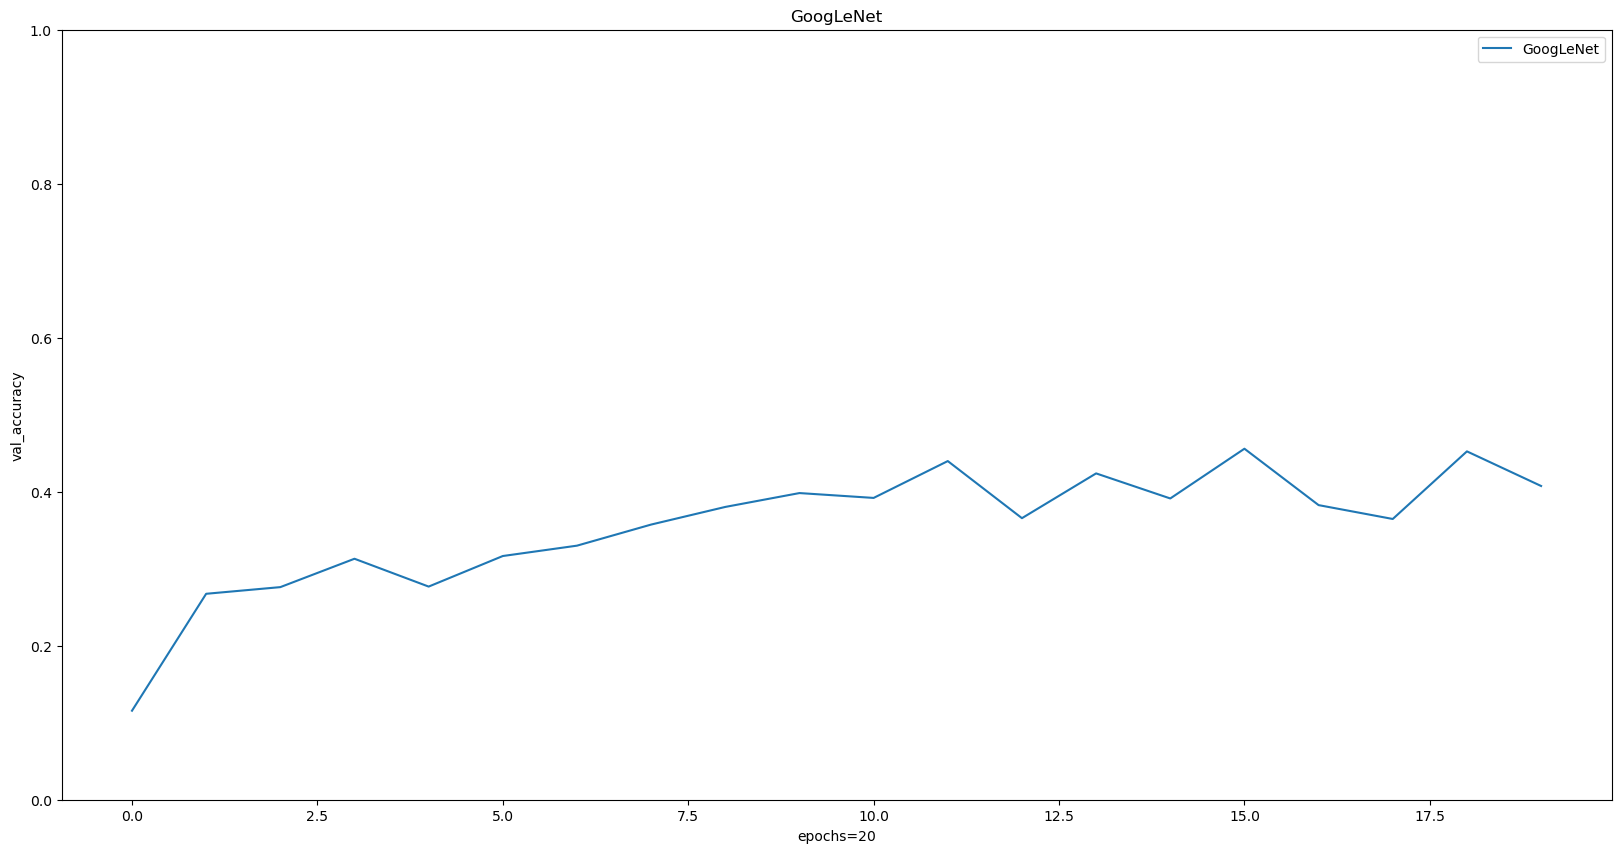

In [82]:
plt.figure(figsize=(20,10))
# plt.plot(hist1.history['val_loss'], label='val_loss1')
# plt.plot(hist2.history['val_loss'], label='val_loss2')
# plt.plot(hist3.history['val_loss'], label='val_loss3')
# plt.plot(hist4.history['val_loss'], label='val_loss4')
plt.plot(hist0.history['val_acc'], label='GoogLeNet')
# plt.plot(hist4.history['val_acc'], label='ESK')
# plt.plot(hist1.history['val_accuracy'], label='Flatten, 2hd')
# plt.plot(hist2.history['val_accuracy'], label='Flatten, 3hd')
# plt.plot(hist3.history['val_accuracy'], label='Flatten, 4hd')
# plt.plot(hist4.history['val_accuracy'], label='Conv2D')
# plt.plot(hist5.history['val_accuracy'], label='Conv2D_2')
plt.ylim(0, 1)
plt.title("GoogLeNet")
plt.ylabel("val_accuracy")
plt.xlabel("epochs=20")
plt.legend()


In [96]:
test = pd.read_csv('./fashionmnist/data/test.csv')
train = pd.read_csv('./fashionmnist/data/train.csv')
submi = pd.read_csv('./fashionmnist/data/sample_submission.csv')


In [97]:
print(test.shape, train.shape, submi.shape)

(10000, 785) (60000, 786) (10000, 2)


# cifar-10 micniproject

### DataSet

In [132]:
tr = os.listdir('./cifar-10/train/train/')
ts = os.listdir('./cifar-10/test/test/')

len(ts)

300000

In [142]:
def saveDir(x, option) : 
    globals()['li'] = []
    
    for idx, y in enumerate(x) :
        if option == "train" :
            src = cv2.imread(f'./cifar-10/train/train/{y}')
        elif option == "test" :
            src = cv2.imread(f'./cifar-10/test/test/{y}')
        else : 
            print("check option")
            break
        
#         blur = cv2.GaussianBlur(src, ksize=(3,3), sigmaX=0.0)
#         gap = src-blur
#         src = src + gap
        
        globals()[f'{option}{idx}'] = src

        li.append(globals()[f'{option}{idx}'])
    
    if option == "train" :
        globals()[f'{option}'] = np.array([li])
#         globals()[f'np{name}'] = globals()[f'np{name}'].reshape(len(globals()[f'np{name}'][0]),
#                                                                len(globals()[f'np{name}'][0][0]),
#                                                                len(globals()[f'np{name}'][0][0][0]))
    elif option == "test" :
        globals()[f'{option}'] = np.array([li])
#         globals()[f'npT{name}'] = globals()[f'npT{name}'].reshape(len(globals()[f'npT{name}'][0]),
#                                                                len(globals()[f'npT{name}'][0][0]),
#                                                                len(globals()[f'npT{name}'][0][0][0]))

In [143]:
saveDir(tr, "train")
saveDir(ts, "test")

In [165]:
x_train = train.reshape(50000, 32, 32, 3)

In [168]:
x_train.shape

(50000, 32, 32, 3)

In [164]:
train.shape

(1, 50000, 32, 32, 3)

In [184]:
test = test.reshape(300000, 32, 32, 3)

In [183]:
test.shape

(1, 300000, 32, 32, 3)

### y_train set

In [133]:
trainLabels = pd.read_csv('./cifar-10/trainLabels.csv')

In [136]:
trainLabels

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [137]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
result = le.fit_transform(trainLabels['label'])
result.shape

(50000,)

In [166]:
y_train = to_categorical(result)

In [167]:
y_train.shape

(50000, 10)

### augmentation

In [177]:
def augmentattion(x_train, y_train, resizing) :
    
    model = Sequential([Rescaling(1/255.),
                        resizing,
                       RandomCrop(32,32), # 32 X 32로 조정되어 중심축이 변경되며 일부가 잘려진다.
                       RandomFlip('horizontal'),
                       RandomRotation(np.random.randint(0,360))])

    Model.build(model, (1, ti.shape[0], ti.shape[1], 3)) # 3차원
    
    globals()[f"x_train_2"] = model(x_train)
                
    # 데이터 결합
    globals()[f"x_train_all"] = np.concatenate((x_train, x_train_2), axis=0) 
    globals()[f"y_train_all"] = np.concatenate((y_train, y_train), axis=0)
    
    
    
resizing = Resizing(int(ti.shape[0]*1.1), int(ti.shape[1]*1.1)) 
augmentattion(x_train, y_train, resizing)

2022-12-07 16:47:41.351936: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9


### Network Setting

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


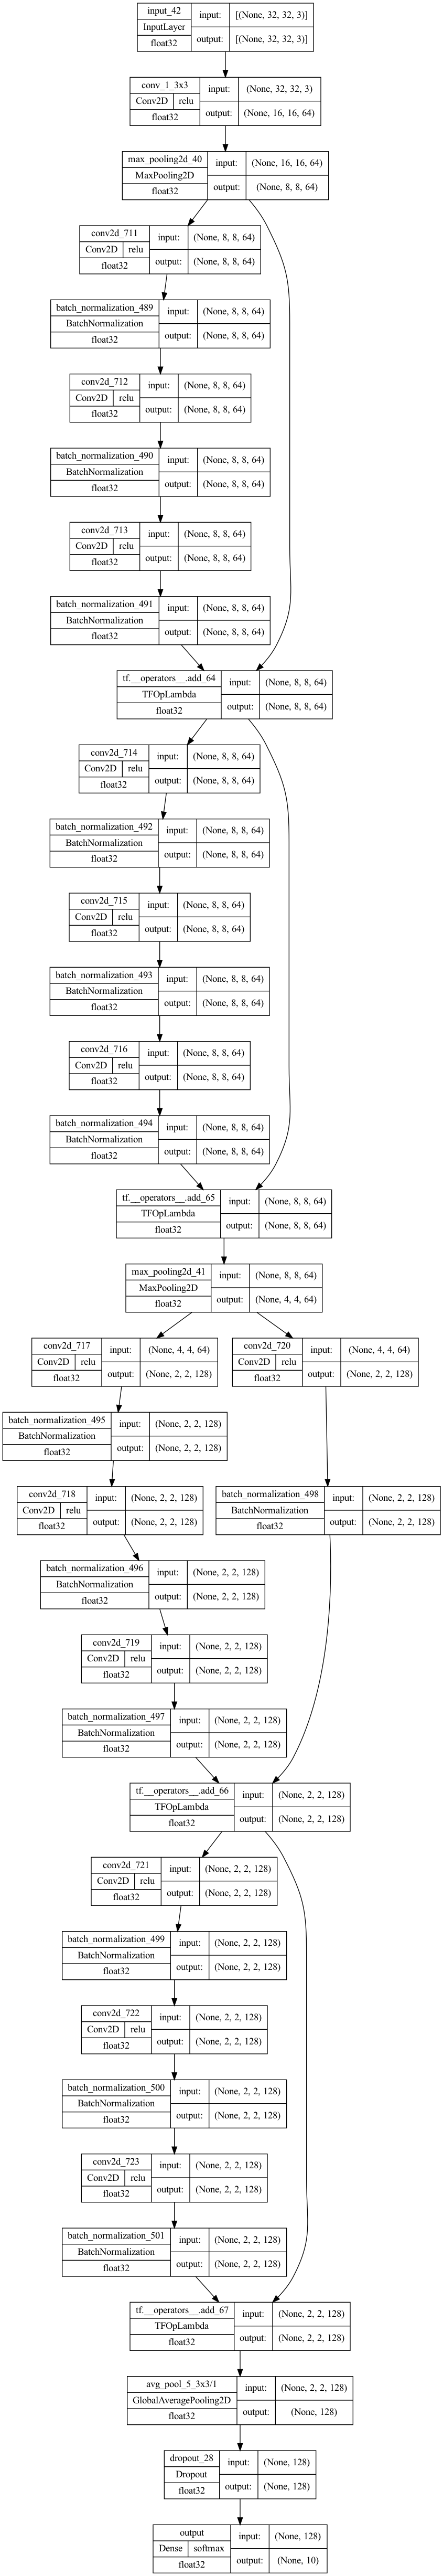

In [190]:
input_layer = Input(x_train_all.shape[1:])

x = Conv2D(64, (7, 7), strides=(2,2), padding='same', activation='relu', name='conv_1_3x3', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2))(x)
x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/1", 3)
x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/2", 3)
# x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/3", 3)
# x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/4", 3)
x = MaxPool2D((2, 2))(x)

x = deepConv2D(x, 128, (3,3), 2, "Conv2D/128/3x3/1", 3)
x = deepConv2D(x, 128, (3,3), 1, "Conv2D/128/3x3/2", 3)
# x = deepConv2D(x, 128, (3,3), 1, "Conv2D/128/3x3/3", 3)
# x = deepConv2D(x, 128, (3,3), 1, "Conv2D/128/3x3/4", 3)

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
# x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

model3 = Model(input_layer, x, name='ResNet_JSR')

plot_model(model3, show_shapes=True, show_dtype=True, show_layer_activations=True)

### Model fit

In [179]:
mdFit(model3, 3, x_train_all, y_train_all, my_callback)

Model: "ResNet_JSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 16, 16, 64)   1792        ['input_41[0][0]']               
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 8, 8, 64)    0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_686 (Conv2D)            (None, 8, 8, 64)     36928       ['max_pooling2d_39[0][0]

                                                                                                  
 batch_normalization_476 (Batch  (None, 4, 4, 128)   512         ['conv2d_698[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_699 (Conv2D)            (None, 4, 4, 128)    147584      ['batch_normalization_476[0][0]']
                                                                                                  
 batch_normalization_477 (Batch  (None, 4, 4, 128)   512         ['conv2d_699[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_701 (Conv2D)            (None, 4, 4, 128)    8320        ['tf.__operators__.add_59[0][0]']
          

Total params: 2,161,546
Trainable params: 2,156,682
Non-trainable params: 4,864
__________________________________________________________________________________________________
Epoch 1/20
625/625 [==============================] - 175s 269ms/step - loss: 2.3922 - acc: 0.0972 - val_loss: 2.3146 - val_acc: 0.1001
Epoch 2/20
625/625 [==============================] - 164s 262ms/step - loss: 2.3177 - acc: 0.1006 - val_loss: 2.3253 - val_acc: 0.0988
Epoch 3/20
625/625 [==============================] - 167s 268ms/step - loss: 2.3108 - acc: 0.1017 - val_loss: 2.3103 - val_acc: 0.1001
Epoch 4/20
625/625 [==============================] - 164s 262ms/step - loss: 2.3075 - acc: 0.1008 - val_loss: 2.3047 - val_acc: 0.0997
Epoch 5/20
625/625 [==============================] - 163s 260ms/step - loss: 2.3057 - acc: 0.1031 - val_loss: 2.3046 - val_acc: 0.1011
Epoch 6/20
625/625 [==============================] - 164s 262ms/step - loss: 2.3052 - acc: 0.1006 - val_loss: 2.3040 - val_acc: 0.0988
Epoch

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "ResNet_JSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 16, 16, 64)   1792        ['input_41[0][0]']               
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 8, 8, 64)    0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_686 (Conv2D)            (None, 8, 8, 64)     36928       ['max_pooling2d_39[0][0]

                                                                                                  
 batch_normalization_476 (Batch  (None, 4, 4, 128)   512         ['conv2d_698[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_699 (Conv2D)            (None, 4, 4, 128)    147584      ['batch_normalization_476[0][0]']
                                                                                                  
 batch_normalization_477 (Batch  (None, 4, 4, 128)   512         ['conv2d_699[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_701 (Conv2D)            (None, 4, 4, 128)    8320        ['tf.__operators__.add_59[0][0]']
          

Total params: 2,161,546
Trainable params: 2,156,682
Non-trainable params: 4,864
__________________________________________________________________________________________________


In [191]:
mdFit(model3, 3, x_train, y_train, my_callback)

Model: "ResNet_JSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 16, 16, 64)   9472        ['input_42[0][0]']               
                                                                                                  
 max_pooling2d_40 (MaxPooling2D  (None, 8, 8, 64)    0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_711 (Conv2D)            (None, 8, 8, 64)     36928       ['max_pooling2d_40[0][0]

                                                                                                  
 batch_normalization_501 (Batch  (None, 2, 2, 128)   512         ['conv2d_723[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 tf.__operators__.add_67 (TFOpL  (None, 2, 2, 128)   0           ['tf.__operators__.add_66[0][0]',
 ambda)                                                           'batch_normalization_501[0][0]']
                                                                                                  
 avg_pool_5_3x3/1 (GlobalAverag  (None, 128)         0           ['tf.__operators__.add_67[0][0]']
 ePooling2D)                                                                                      
                                                                                                  
 dropout_2

KeyboardInterrupt: 

In [185]:
result = best_model2.predict(test)

9375/9375 [==============================] - 208s 22ms/step


In [195]:
np.set_printoptions(threshold=300)
print(result, )
# np.set_printoptions(threshold=np.inf)

[[0.09656996 0.10065443 0.10704459 ... 0.10327828 0.1061478  0.10029434]
 [0.092815   0.10017113 0.11084211 ... 0.10510591 0.10590904 0.09612005]
 [0.09159376 0.0947929  0.11292394 ... 0.10678423 0.10482638 0.09024297]
 ...
 [0.09257189 0.09862454 0.1089929  ... 0.10425986 0.10511063 0.09582075]
 [0.08885594 0.10080108 0.11355381 ... 0.10812567 0.10424359 0.09161156]
 [0.09776986 0.10545836 0.10801612 ... 0.10258213 0.10853426 0.10328164]]


In [189]:
pd_sample = pd.read_csv('./cifar-10/sampleSubmission.csv')
pd_sample

,id,label
0,1,cat
1,2,cat
2,3,cat
3,4,cat
4,5,cat
...,...,...
299995,299996,cat
299996,299997,cat
299997,299998,cat
299998,299999,cat
